# Context
---
The is related to a restaurant located at the South of Brasil.

This dataset is combining several variables from different nature, such as: Customer, Whether, Sales History, Competitors and more.

The idea behind is to aggregate on a singular `dataset.csv`, all the necessary information to predict the next day sales (VENDAS)

# Metric 
---
RMSE with or without cross validation

# Installing Kernal Dependencies

In [386]:
pip install eli5

# Reading CSV

---

Here we are reading the dataset and adding a *df* variable

In [387]:
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

df = pd.read_csv('dataset.csv')
pd.set_option('display.max_rows', 500)

# Pre processing the Dataset

---

Here we are adding some new columns which may increase the model perfomance

In [388]:
import math

def get_trimestres_indicadores(series, indicator, period):
    val = []
    trimestres_template = df.groupby(pd.to_datetime(df['DATA']).dt.to_period(period))['VENDAS'].agg(indicator)
    for i in range(len(series)):
        val.append(trimestres_template[series[i]].astype(int))
    return val

def get_vendas_ontem(df):
    first_row = 1
    df_temp = df['VENDAS'].shift(1)
    df_temp[0:first_row] = df[0:first_row]['VENDAS']
    
    for i in range(len(df_temp)):
        row_value = df_temp[i]
        inner_index = i
        while row_value == 0 or math.isnan(row_value):
            inner_index = inner_index - 1
            row_value = df_temp[inner_index]

        df_temp[i] = row_value
    return df_temp

df.insert(loc=20, column='VENDAS_MEDIA_TRIM', value=(get_trimestres_indicadores(pd.to_datetime(df['DATA']).dt.to_period('Q').astype(str), 'mean', 'Q')))
df.insert(loc=21, column='VENDAS_MEDIA_MES', value=(get_trimestres_indicadores(pd.to_datetime(df['DATA']).dt.to_period('M').astype(str), 'mean', 'M')))
df.insert(loc=22, column='VENDAS_STD_TRIM', value=(get_trimestres_indicadores(pd.to_datetime(df['DATA']).dt.to_period('Q').astype(str), 'std', 'Q')))
df.insert(loc=23, column='VENDAS_STD_MES', value=(get_trimestres_indicadores(pd.to_datetime(df['DATA']).dt.to_period('M').astype(str), 'std', 'M')))
df.insert(loc=24, column='VENDAS_ONTEM', value=(get_vendas_ontem(df)))

df['DATA'] = (pd.to_datetime(df['DATA'], dayfirst=True))

# Removing Outliers

---

Here we are removing the records which are appearing less than 3% (the outliers)

In [389]:
df = df.query('VENDAS < 200 and VENDAS > 70')
df = df.query('FECHADO == 0 and ABERTO == 1')

# Dropping Columns

---

Here we are removing the columns that are ambiguos

In [390]:
df = df.drop(columns=['FECHADO', 'ABERTO', 'DS', 'DATA_NAO_FESTIVA', 'BAIXA_TEMPORADA', 'SEMANA_DE_NAO_PAGAMENTO', 'NAO_FERIADO'])

# saving variable for later
all_columns = np.array(df.columns)

# Exploratory Data Analysis (EDA)
---
The main idea here is to investigate and get to know better our dataset

## Basic 

Here are looking for IsNull & IsNA & Checking the Dataset columns


In [391]:
print(f'Does the Dataset has null values?: {df.isnull().values.any()}')
print(f'Does the Dataset has N/A values?: {df.isna().values.any()}')
print(f'What is the dataset format?: {df.shape}')
df.info()

Does the Dataset has null values?: False
Does the Dataset has N/A values?: False
What is the dataset format?: (715, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 0 to 751
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATA                  715 non-null    datetime64[ns]
 1   VENDAS                715 non-null    int64         
 2   FDS                   715 non-null    int64         
 3   DATA_FESTIVA          715 non-null    int64         
 4   VESPERA_DATA_FESTIVA  715 non-null    int64         
 5   POS_DATA_FESTIVA      715 non-null    int64         
 6   FERIADO               715 non-null    int64         
 7   SEMANA_PAGAMENTO      715 non-null    int64         
 8   ALTA_TEMPORADA        715 non-null    int64         
 9   QTD_CONCORRENTES      715 non-null    int64         
 10  PRECIPITACAO          715 non-null    int64         
 11  TEMPERATURA     

In [392]:
df

,DATA,VENDAS,FDS,DATA_FESTIVA,VESPERA_DATA_FESTIVA,POS_DATA_FESTIVA,FERIADO,SEMANA_PAGAMENTO,ALTA_TEMPORADA,QTD_CONCORRENTES,PRECIPITACAO,TEMPERATURA,UMIDADE,VENDAS_MEDIA_TRIM,VENDAS_MEDIA_MES,VENDAS_STD_TRIM,VENDAS_STD_MES,VENDAS_ONTEM
0,2018-02-14,132,0,0,0,1,0,0,0,7,5,30,70,142,148,34,34,132.0
1,2018-02-15,149,0,0,0,1,0,0,0,7,5,30,65,142,148,34,34,132.0
2,2018-02-16,130,0,0,0,0,0,0,0,7,5,35,65,142,148,34,34,149.0
3,2018-02-17,174,1,0,0,0,0,0,0,7,5,35,70,142,148,34,34,130.0
4,2018-02-18,185,1,0,0,0,0,0,0,7,5,35,60,142,148,34,34,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,2020-03-01,87,1,0,0,0,0,0,1,13,5,35,70,100,97,28,17,117.0
747,2020-03-02,99,0,0,0,0,0,0,1,13,5,30,70,100,97,28,17,87.0
749,2020-03-04,98,0,0,0,0,0,0,1,13,5,30,70,100,97,28,17,70.0
750,2020-03-05,121,0,0,0,0,0,1,1,13,5,30,70,100,97,28,17,98.0


## Overview

Here are getting to know more about the whole period, the semester, the standard deviation and etc.

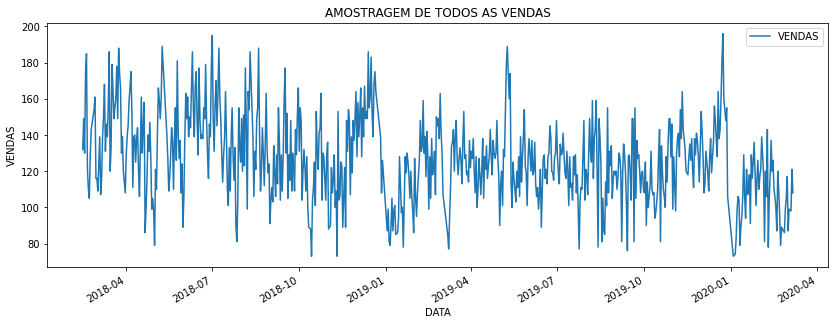

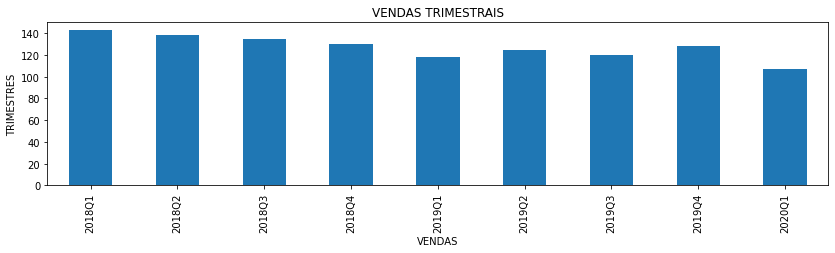

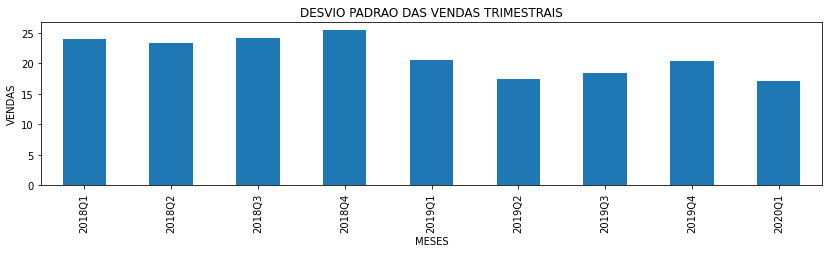

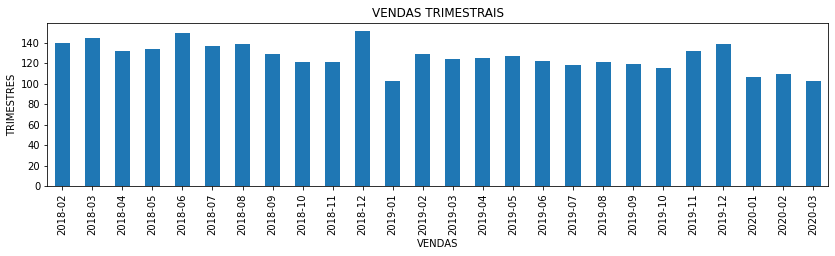

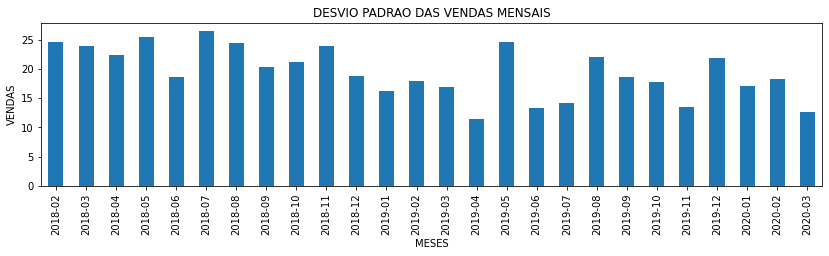

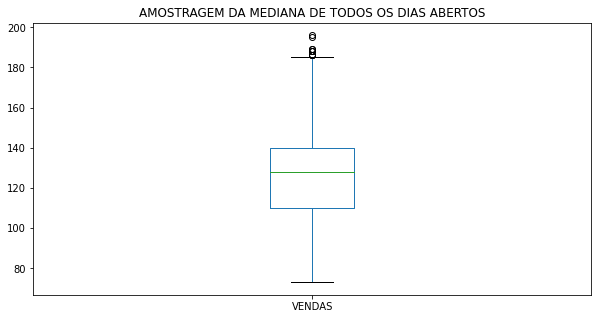

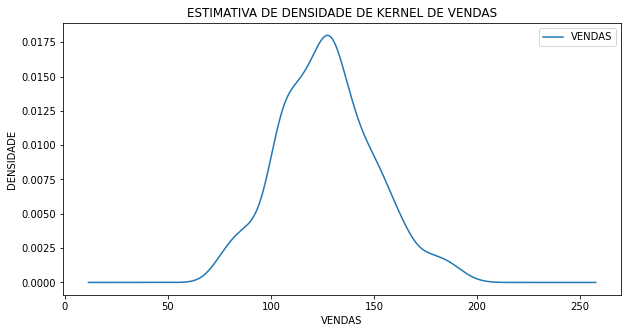

In [393]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = df.plot(y=['VENDAS'], x='DATA', figsize=(14, 5))
plt.legend(loc=1)
plt.title('AMOSTRAGEM DE TODOS AS VENDAS')
plt.xlabel('DATA')
plt.ylabel('VENDAS')
plt.show()    

df_quarter = pd.DataFrame({'DATA': pd.to_datetime(df['DATA']), 'TEMPERATURA': df['TEMPERATURA'], 'VENDAS': df['VENDAS']})

df_quarter.groupby(df['DATA'].dt.to_period('Q'))['VENDAS'].agg('mean').plot(y='VENDAS', x='DATA', kind='bar', figsize=(14, 3))
plt.title('VENDAS TRIMESTRAIS')
plt.xlabel('VENDAS')
plt.ylabel('TRIMESTRES')
plt.show()

df_quarter.groupby(df['DATA'].dt.to_period('Q'))['VENDAS'].agg('std').plot(y='VENDAS', x='DATA', kind='bar', figsize=(14, 3))
plt.title('DESVIO PADRAO DAS VENDAS TRIMESTRAIS')
plt.xlabel('MESES')
plt.ylabel('VENDAS')
plt.show()

df_quarter.groupby(df['DATA'].dt.to_period('M'))['VENDAS'].agg('mean').plot(y='VENDAS', x='DATA', kind='bar', figsize=(14, 3))
plt.title('VENDAS TRIMESTRAIS')
plt.xlabel('VENDAS')
plt.ylabel('TRIMESTRES')
plt.show()

df_quarter.groupby(df['DATA'].dt.to_period('M'))['VENDAS'].agg('std').plot(y='VENDAS', x='DATA', kind='bar', figsize=(14, 3))
plt.title('DESVIO PADRAO DAS VENDAS MENSAIS')
plt.xlabel('MESES')
plt.ylabel('VENDAS')
plt.show()

df.plot(y='VENDAS', x='DATA', figsize=(10, 5), kind='box')
plt.title('AMOSTRAGEM DA MEDIANA DE TODOS OS DIAS ABERTOS')
plt.show()

df.plot(y='VENDAS', x='DATA', figsize=(10, 5), kind='kde')
plt.legend(loc=1)
plt.title('ESTIMATIVA DE DENSIDADE DE KERNEL DE VENDAS')
plt.xlabel('VENDAS')
plt.ylabel('DENSIDADE')
plt.show()

## Features & Correlation

Here we are checking what is the correlatio between a feature and our target variable, to check how it is influence

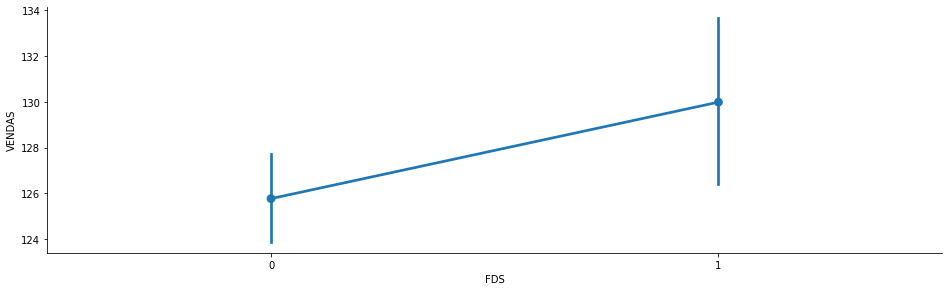

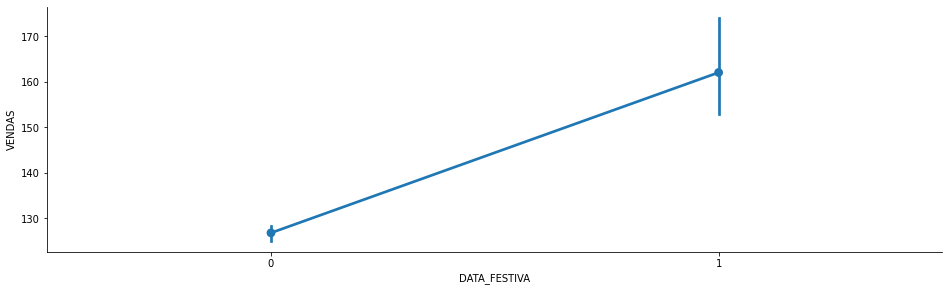

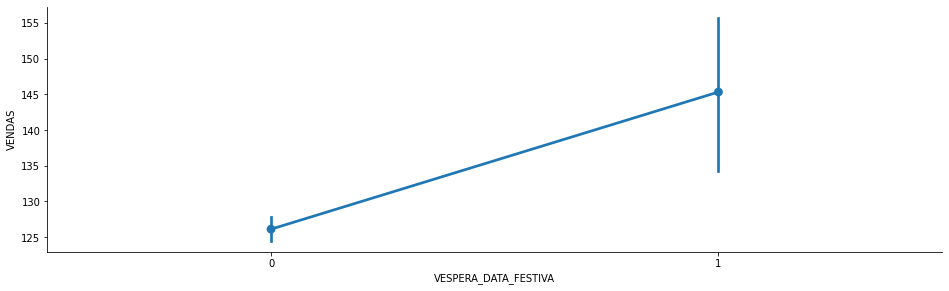

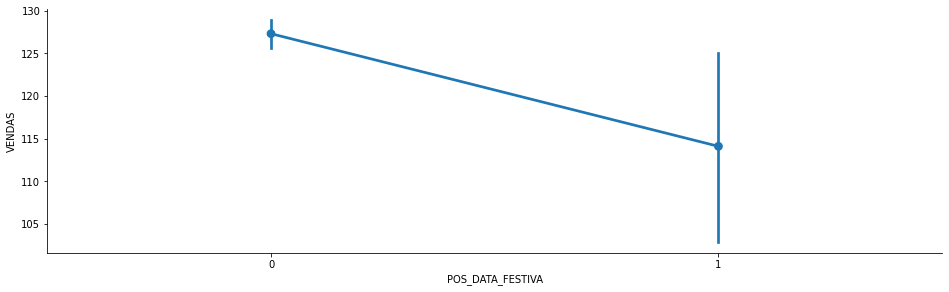

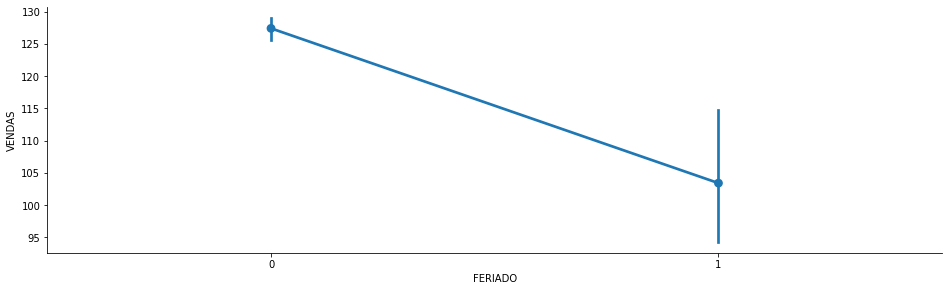

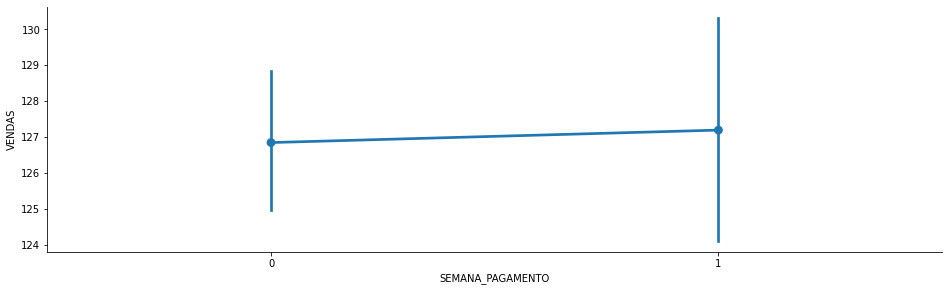

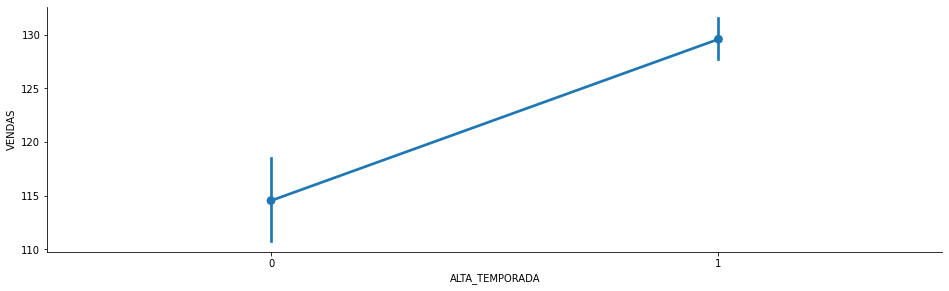

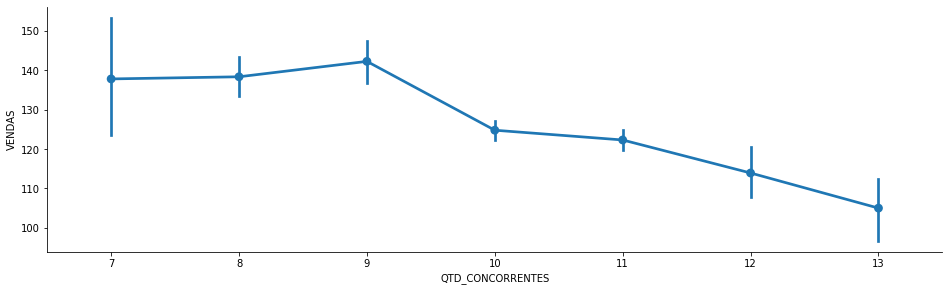

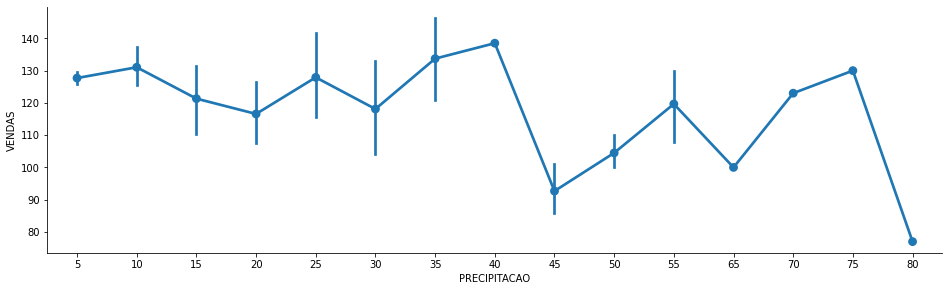

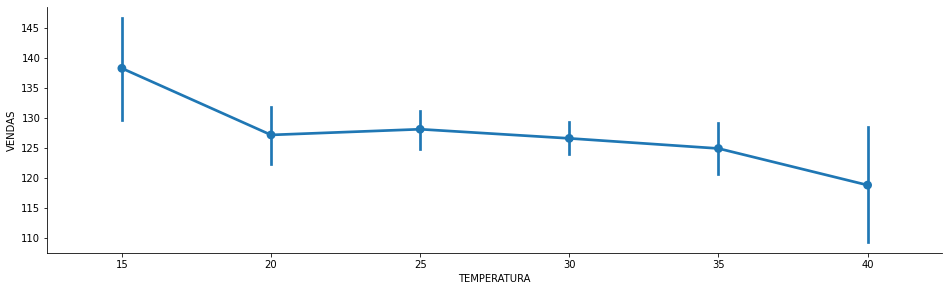

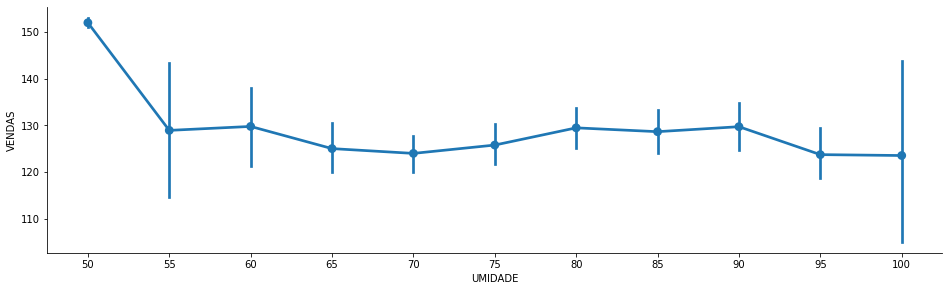

In [394]:
df_scatter = df.sort_values(by=['VENDAS'], ascending=True)

c = sns.catplot('FDS', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('DATA_FESTIVA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('VESPERA_DATA_FESTIVA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('POS_DATA_FESTIVA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('FERIADO', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('SEMANA_PAGAMENTO', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('ALTA_TEMPORADA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('QTD_CONCORRENTES', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('PRECIPITACAO', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('TEMPERATURA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('UMIDADE', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

# LSTM Hypothesis
---
Since LSTM works well with time-series-like dataset, we will use it

## Permutation Importance

Here we are checking what are the most important features for the LSTM algorithm


In [395]:
import numpy as np
import eli5

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from eli5.sklearn import PermutationImportance

# creating feature dataset
features_to_drop_default = ['DATA', 'VENDAS']
features_to_drop_from_feature_analysis = ['SEMANA_PAGAMENTO', 'PRECIPITACAO']
features_to_drop_from_feature_importance = ['TEMPERATURA', 'POS_DATA_FESTIVA', 'FDS', 'VESPERA_DATA_FESTIVA', 'ALTA_TEMPORADA', 'VENDAS_MEDIA_TRIM', 'VENDAS_STD_MES', 'VENDAS_STD_TRIM']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_feature_importance

# creating target dataset
outputs_to_drop = ['DATA', 'FDS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'FERIADO', 'SEMANA_PAGAMENTO', 'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE', 'VENDAS_MEDIA_TRIM', 'VENDAS_MEDIA_MES', 'VENDAS_STD_TRIM', 'VENDAS_STD_MES', 'VENDAS_ONTEM']

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X = df.drop(columns=features_to_drop)
y = df.drop(columns=outputs_to_drop)

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Feature Engineering

Here we are scaling / normalizing our features leftovers

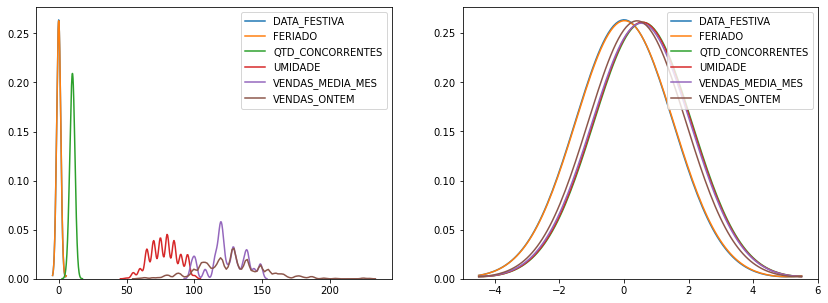

In [396]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# plot scaling
scaled_X_train = pd.DataFrame(X_train, columns=leftovers)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))

for i in range(len(leftovers)):
    column = leftovers[i]
    sns.kdeplot(df[column], bw=1.5, ax=ax1)

for j in range(len(leftovers)):
    column = leftovers[j]
    sns.kdeplot(scaled_X_train[column], bw=1.5, ax=ax2)

plt.show()

## Model Creation, Fitting, Tunning & Prediction

Here we are creating our MLPRegressor model, tunning, fitting, predicting and ploting the results


RMSE: 16.42
MAE: 13.00
R2: 0.02


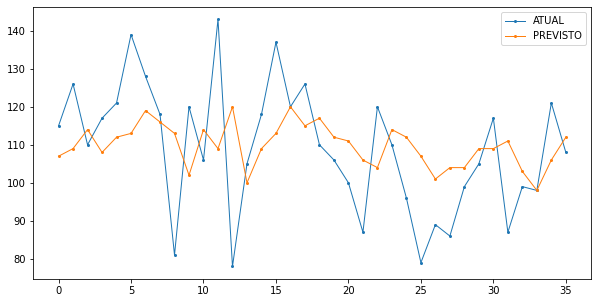

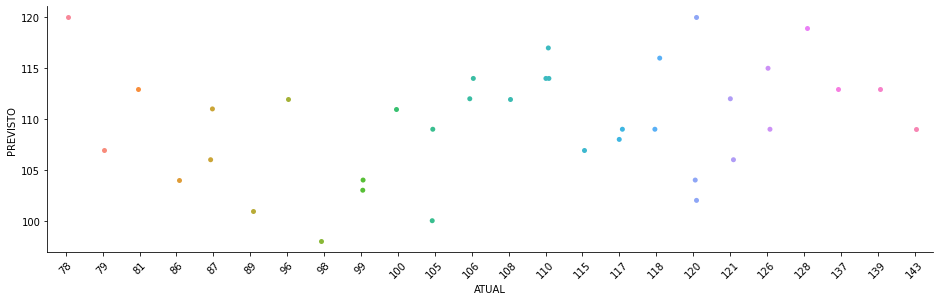

In [397]:
# imports
import seaborn as sns
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor

# reshape to 3D
train_X = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
train_y = np.array(y_train).reshape((y_train.shape[0], 1, y_train.shape[1]))
test_X = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
sizee = (int(train_X.shape[2] - 1) * -1)

# model
def base_model():
    lstm = Sequential()
    lstm.add(LSTM(190, return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(190, return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(190, return_sequences=False))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')
    return lstm
lstm = KerasRegressor(build_fn=base_model)

# manual training
lstm.fit(train_X, train_y, epochs=200, batch_size=20, shuffle=False, verbose=False)
y_pred_lstm = lstm.predict(test_X).round().astype(int)
y_pred_lstm = y_pred_lstm.reshape((y_pred_lstm.shape[0], 1))
test_X = test_X.reshape((test_X.shape[0], train_X.shape[2]))
rmse = metrics.mean_squared_error(y_test, y_pred_lstm, squared=False)
mae = metrics.mean_absolute_error(y_test, y_pred_lstm)
print(f'RMSE: %.2f' % rmse)
print(f'MAE: %.2f' % mae)
print(f'R2: %.2f' % metrics.r2_score(y_test, y_pred_lstm))

# plot
df1 = pd.DataFrame({'ATUAL': y_test.values.flatten(), 'PREVISTO': y_pred_lstm.flatten()})
df1.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

# scatter
c = sns.catplot('ATUAL', 'PREVISTO', data=pd.DataFrame({'PREVISTO': y_pred_lstm.flatten(), 'ATUAL': y_test.values.flatten() }))
c.set_xticklabels(rotation=45)
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

# GradientBoostingRegressor Hypothesis
---
Since GB works well with splitting the features and exploiting them, we will use it

## Permutation Importance

Here we are checking what are the most important features for the **GradientBoostingRegressor** algorithm


In [398]:
import numpy as np
import eli5

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from eli5.sklearn import PermutationImportance

################################################ 1st Round

# creating feature dataset
features_to_drop_default = ['DATA', 'VENDAS']
features_to_drop_from_feature_analysis = ['SEMANA_PAGAMENTO', 'PRECIPITACAO']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis 

# creating target dataset
outputs_to_drop = ['DATA', 'FDS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'FERIADO', 'SEMANA_PAGAMENTO', 'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE', 'VENDAS_MEDIA_TRIM', 'VENDAS_MEDIA_MES', 'VENDAS_STD_TRIM', 'VENDAS_STD_MES', 'VENDAS_ONTEM']

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X = df.drop(columns=features_to_drop)
y = df.drop(columns=outputs_to_drop)

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# permutation importance
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

################################################ 2nd Round

# creating feature dataset
features_to_drop_from_permutation = ['VENDAS_STD_MES', 'FDS', 'POS_DATA_FESTIVA', 'UMIDADE', 'TEMPERATURA', 'VESPERA_DATA_FESTIVA']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_permutation

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X = df.drop(columns=features_to_drop)
y = df.drop(columns=outputs_to_drop)

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# permutation importance
nn = GradientBoostingRegressor()
nn.fit(X_train, y_train)
perm = PermutationImportance(nn, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

################################################ 3rd Round
# creating feature dataset
features_to_drop_from_permutation_2nd_round = ['ALTA_TEMPORADA']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_permutation + features_to_drop_from_permutation + features_to_drop_from_permutation_2nd_round

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X = df.drop(columns=features_to_drop)
y = df.drop(columns=outputs_to_drop)

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# permutation importance
nn = GradientBoostingRegressor()
nn.fit(X_train, y_train)
perm = PermutationImportance(nn, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

Weight,Feature
0.1973 ± 0.2293,VENDAS_ONTEM
0.0194 ± 0.0168,VENDAS_MEDIA_MES
0 ± 0.0000,VENDAS_STD_TRIM
0 ± 0.0000,VENDAS_MEDIA_TRIM
0 ± 0.0000,QTD_CONCORRENTES
0 ± 0.0000,FERIADO
0 ± 0.0000,DATA_FESTIVA


## Feature Engineering

Here we are scaling / normalizing our features leftovers

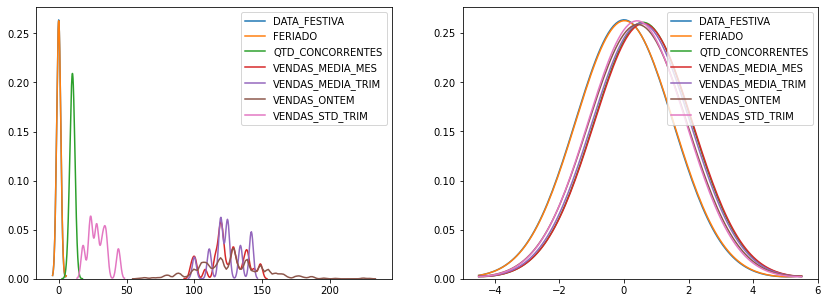

In [399]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# plot scaling
scaled_X_train = pd.DataFrame(X_train, columns=leftovers)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))

for i in range(len(leftovers)):
    column = leftovers[i]
    sns.kdeplot(df[column], bw=1.5, ax=ax1)

for j in range(len(leftovers)):
    column = leftovers[j]
    sns.kdeplot(scaled_X_train[column], bw=1.5, ax=ax2)

plt.show()

## Model Creation, Fitting, Tunning & Prediction 

Here we are creating our GradientBoostingRegressor model, tunning, fitting, predicting and ploting the results 

RMSE (cross validation): 18.50
MAE (cross validation): 13.97
RMSE: 18.51
MAE: 14.64
R2: -0.24


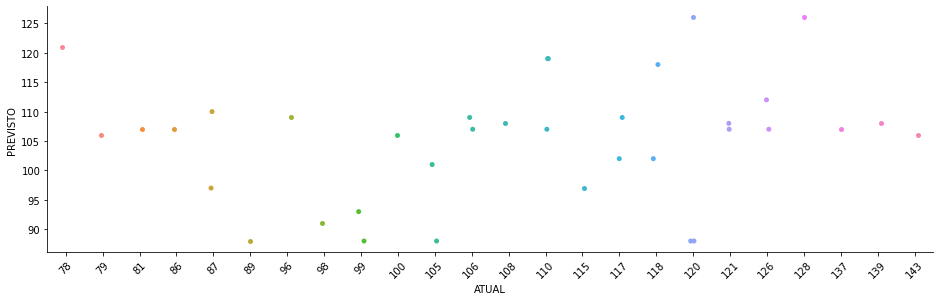

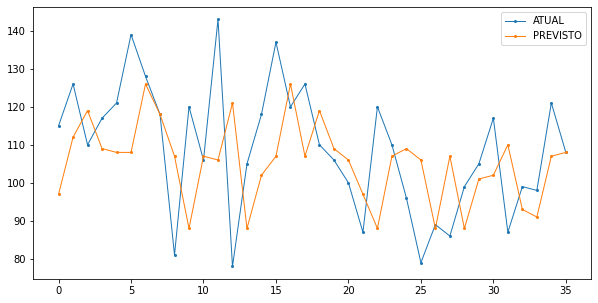

In [400]:
# imports
from sklearn.ensemble import GradientBoostingRegressor

# model
gb = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=25,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=21, min_samples_split=16,
                          min_weight_fraction_leaf=0.0, n_estimators=139,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# cross validation
scores_rmse = cross_val_score(gb, X, y, scoring='neg_root_mean_squared_error', cv=5)
scores_mae = cross_val_score(gb, X, y, scoring='neg_mean_absolute_error', cv=5)
print(f'RMSE (cross validation): %.2f' % np.abs(scores_rmse).min())
print(f'MAE (cross validation): %.2f' % np.abs(scores_mae).min())

# manual training
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test).round().astype(int)
print(f'RMSE: %.2f' % metrics.mean_squared_error(y_test, y_pred_gb, squared=False))
print(f'MAE: %.2f' % metrics.mean_absolute_error(y_test, y_pred_gb))
print(f'R2: %.2f' % metrics.r2_score(y_test, y_pred_gb))

# scatter
c = sns.catplot('ATUAL', 'PREVISTO', data=pd.DataFrame({'PREVISTO': y_pred_gb.flatten(), 'ATUAL': y_test.values.flatten() }))
c.set_xticklabels(rotation=45)
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

# plot
df1 = pd.DataFrame({'ATUAL': y_test.values.flatten(), 'PREVISTO': y_pred_gb.flatten()})
df1.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

# MLPRegressor Hypothesis
---
Since MLP works well with several different features, we will use it

## Permutation Importance 

Here we are checking what are the most important features for the **MLPRegressor** algorithm


In [401]:
import numpy as np
import eli5

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPRegressor
from eli5.sklearn import PermutationImportance

################################################ 1st Round

# all columns
all_columns = ['DATA', 'VENDAS', 'FDS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'FERIADO', 'SEMANA_PAGAMENTO', 'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE', 'VENDAS_MEDIA_TRIM', 'VENDAS_MEDIA_MES', 'VENDAS_STD_TRIM', 'VENDAS_STD_MES', 'VENDAS_ONTEM']

# creating feature dataset
features_to_drop_default = ['DATA', 'VENDAS']
features_to_drop_from_feature_analysis = ['SEMANA_PAGAMENTO', 'PRECIPITACAO']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis 

# creating target dataset
outputs_to_drop = ['DATA', 'FDS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'FERIADO', 'SEMANA_PAGAMENTO', 'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE', 'VENDAS_MEDIA_TRIM', 'VENDAS_MEDIA_MES', 'VENDAS_STD_TRIM', 'VENDAS_STD_MES', 'VENDAS_ONTEM']

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X = df.drop(columns=features_to_drop)
y = df.drop(columns=outputs_to_drop)

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# permutation importance
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

################################################ 2nd Round

# creating feature dataset
features_to_drop_from_permutation = ['TEMPERATURA', 'VESPERA_DATA_FESTIVA']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_permutation

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X = df.drop(columns=features_to_drop)
y = df.drop(columns=outputs_to_drop)

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# permutation importance
nn = GradientBoostingRegressor()
nn.fit(X_train, y_train)
perm = PermutationImportance(nn, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

################################################ 3rd Round
# creating feature dataset
features_to_drop_from_permutation_2nd_round = ['FDS', 'UMIDADE', 'ALTA_TEMPORADA']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_permutation + features_to_drop_from_permutation + features_to_drop_from_permutation_2nd_round

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X = df.drop(columns=features_to_drop)
y = df.drop(columns=outputs_to_drop)

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# permutation importance
nn = GradientBoostingRegressor()
nn.fit(X_train, y_train)
perm = PermutationImportance(nn, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

Weight,Feature
0.1078 ± 0.1785,VENDAS_ONTEM
0.0223 ± 0.0513,POS_DATA_FESTIVA
0 ± 0.0000,VENDAS_STD_TRIM
0 ± 0.0000,VENDAS_MEDIA_TRIM
0 ± 0.0000,QTD_CONCORRENTES
0 ± 0.0000,FERIADO
0 ± 0.0000,DATA_FESTIVA
-0.0004 ± 0.0026,VENDAS_MEDIA_MES
-0.0011 ± 0.0220,VENDAS_STD_MES


## Feature Engineering 

Here we are scaling / normalizing our features leftovers

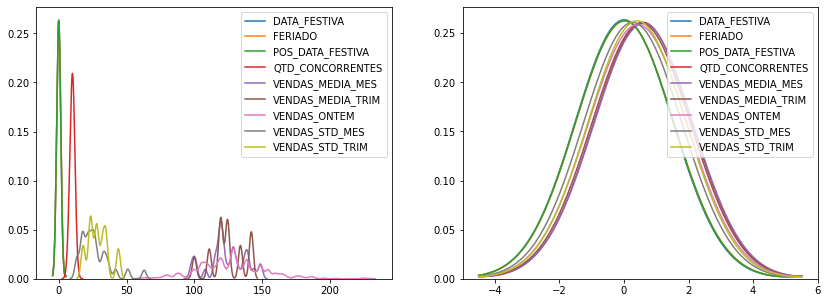

In [402]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# plot scaling
scaled_X_train = pd.DataFrame(X_train, columns=leftovers)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))

for i in range(len(leftovers)):
    column = leftovers[i]
    sns.kdeplot(df[column], bw=1.5, ax=ax1)

for j in range(len(leftovers)):
    column = leftovers[j]
    sns.kdeplot(scaled_X_train[column], bw=1.5, ax=ax2)

plt.show()

## Model Creation, Fitting, Tunning & Prediction

Here we are creating our MLPRegressor model, tunning, fitting, predicting and ploting the results 

RMSE (cross validation): 16.11
MAE (cross validation): 12.56
RMSE: 16.28
MAE: 12.47
R2: 0.04


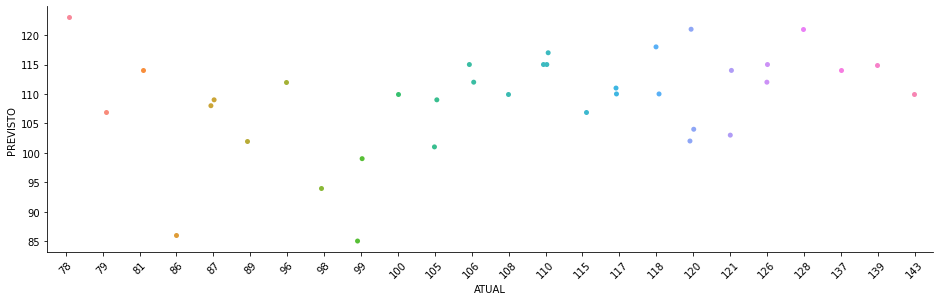

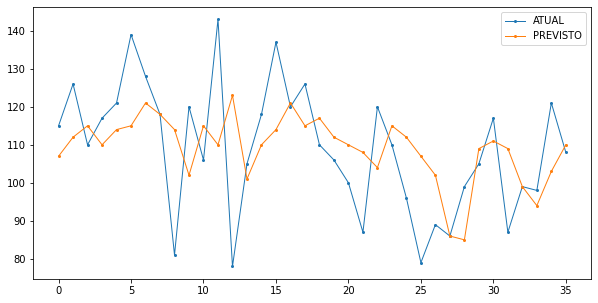

In [403]:
# imports
from sklearn.neural_network import MLPRegressor

# model
mlp = MLPRegressor(activation='identity', alpha=0.0001, batch_size=400, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(89), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=100,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

# cross validation
scores_rmse = cross_val_score(mlp, X, y, scoring='neg_root_mean_squared_error', cv=5)
scores_mae = cross_val_score(mlp, X, y, scoring='neg_mean_absolute_error', cv=5)
print(f'RMSE (cross validation): %.2f' % np.abs(scores_rmse).min())
print(f'MAE (cross validation): %.2f' % np.abs(scores_mae).min())

# manual training
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test).round().astype(int)
print(f'RMSE: %.2f' % metrics.mean_squared_error(y_test, y_pred_mlp, squared=False))
print(f'MAE: %.2f' % metrics.mean_absolute_error(y_test, y_pred_mlp))
print(f'R2: %.2f' % metrics.r2_score(y_test, y_pred_mlp))

# scatter
c = sns.catplot('ATUAL', 'PREVISTO', data=pd.DataFrame({'PREVISTO': y_pred_mlp.flatten(), 'ATUAL': y_test.values.flatten() }))
c.set_xticklabels(rotation=45)
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

# plot
df1 = pd.DataFrame({'ATUAL': y_test.values.flatten(), 'PREVISTO': y_pred_mlp.flatten()})
df1.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

# Ensemble Technique

---

Lets combine our weak learners into a better one by joining all

## Manually
---
Here we get the results from the 3 different algorithms and create new columns and dataset

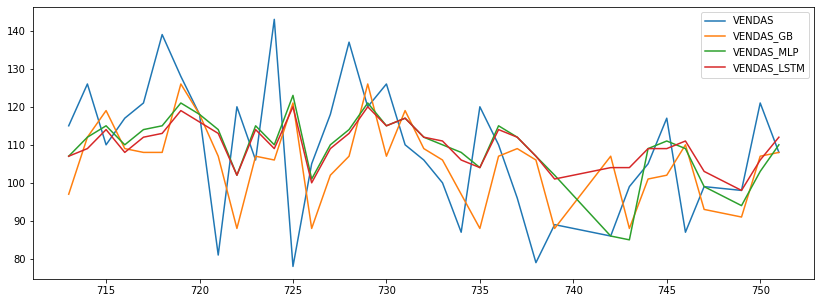

In [404]:
df_ensemble = pd.DataFrame()
df_ensemble.insert(loc=0, column='VENDAS', value=(y_test['VENDAS']))
df_ensemble.insert(loc=1, column='VENDAS_GB', value=(y_pred_gb))
df_ensemble.insert(loc=2, column='VENDAS_MLP', value=(y_pred_mlp))
df_ensemble.insert(loc=3, column='VENDAS_LSTM', value=(y_pred_lstm))
df_ensemble.plot(figsize=(14, 5))

Here we are joining the predictions from the previous model into the same dataset, inverting the scale to check

In [405]:
X_test = scaler.inverse_transform(X_test)
df_ensemble = pd.DataFrame(X_test)
df_ensemble.rename({
    0: "DATA_FESTIVA",
    1: "POS_DATA_FESTIVA",
    2: "FERIADO",
    3: "QTD_CONCORRENTES",
    4: "VENDAS_MEDIA_TRIM",
    5: "VENDAS_MEDIA_MES",
    6: "VENDAS_STD_TRIM",
    7: "VENDAS_STD_MES",
    8: "VENDAS_ONTEM"
    }, axis='columns',inplace=True)
df_ensemble.insert(loc=9, column='VENDAS_GB', value=(y_pred_gb))
df_ensemble.insert(loc=10, column='VENDAS_MLP', value=(y_pred_mlp))
df_ensemble.insert(loc=11, column='VENDAS_LSTM', value=(y_pred_lstm))
df_ensemble

,DATA_FESTIVA,POS_DATA_FESTIVA,FERIADO,QTD_CONCORRENTES,VENDAS_MEDIA_TRIM,VENDAS_MEDIA_MES,VENDAS_STD_TRIM,VENDAS_STD_MES,VENDAS_ONTEM,VENDAS_GB,VENDAS_MLP,VENDAS_LSTM
0,0.0,0.0,0.0,12.0,100.0,100.0,28.0,27.0,101.0,97,107,107
1,0.0,0.0,0.0,12.0,100.0,100.0,28.0,27.0,115.0,112,112,109
2,0.0,0.0,0.0,12.0,100.0,100.0,28.0,27.0,126.0,119,115,114
3,0.0,0.0,0.0,12.0,100.0,100.0,28.0,27.0,110.0,109,110,108
4,0.0,0.0,0.0,12.0,100.0,101.0,28.0,33.0,117.0,108,114,112
5,0.0,0.0,0.0,12.0,100.0,101.0,28.0,33.0,121.0,108,115,113
6,0.0,0.0,0.0,12.0,100.0,101.0,28.0,33.0,139.0,126,121,119
7,0.0,0.0,0.0,12.0,100.0,101.0,28.0,33.0,128.0,118,118,116
8,0.0,0.0,0.0,12.0,100.0,101.0,28.0,33.0,118.0,107,114,113
9,0.0,0.0,0.0,12.0,100.0,101.0,28.0,33.0,81.0,88,102,102


Here we are scaling again to fit the ensemble technique

In [406]:
X_test = scaler.transform(X_test)

## VotingRegressor

Here we are feeding the VotingRegressor Ensemble Algorithm with GP and MLP and checking the results

RMSE: 17.34
MAE: 13.61
R2: -0.09


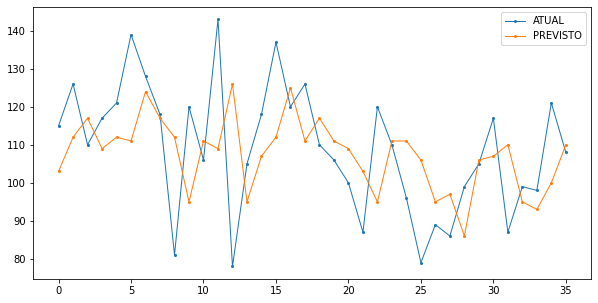

In [407]:
from sklearn.ensemble import VotingRegressor

softvoting = VotingRegressor(estimators=[('gb', gb),('mlp', mlp)])
softvoting.fit(X_train, y_train)
y_pred = softvoting.predict(X_test).round().astype(int)
print(f'RMSE: %.2f' % metrics.mean_squared_error(y_test, y_pred, squared=False))
print(f'MAE: %.2f' % metrics.mean_absolute_error(y_test, y_pred))
print(f'R2: %.2f' % metrics.r2_score(y_test, y_pred))

# plot
df1 = pd.DataFrame({'ATUAL': y_test.values.flatten(), 'PREVISTO': y_pred3.flatten()})
df1.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

## StackingRegressor

Here we are feeding the StackingRegressor Ensemble Algorithm with GP and MLP, adding a Meta Regressor as the SVR (Support Vector Machine) and checking the results

In [408]:
from mlxtend.regressor import StackingRegressor
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf')
stregr = StackingRegressor(regressors=[gb, mlp], meta_regressor=svr_rbf)
stregr.fit(X_train, y_train)
y_pred = stregr.predict(X_test).round().astype(int)
y_pred = y_pred.reshape(y_pred.shape[0], 1)
print(f'RMSE: %.2f' % metrics.mean_squared_error(y_test, y_pred, squared=False))

RMSE: 18.26


# Final Model

---
Lets export and consume our final model

## Exporting
---
Since the VotingRegressor Ensemble Technique had the best RMSE, we use it

In [409]:
from sklearn.externals import joblib
joblib.dump(softvoting, 'Model.pkl')

['Model.pkl']

## Loading
---
Here we are loading our exported model again to check if it really was successfully exported

In [410]:
final_model = joblib.load('Model.pkl')

## Testing
---
Here we are testing our exported and now loaded model, to assert what is the models predictiong given a manual set of test parameters

In [411]:
features = []
features.append(0) # DATA_FESTIVA
features.append(0) # FERIADO
features.append(0) # POS_DATA_FESTIVA
features.append(13) # QTD_CONCORRENTES
features.append(140) # VENDAS_MEDIA_MES
features.append(150) # VENDAS_MEDIA_TRIM
features.append(144) # VENDAS_ONTEM
features.append(24) # VENDAS_STD_MES
features.append(25) # VENDAS_STD_TRIM

test_X_manual = scaler.fit_transform([features])
y_pred_final = final_model.predict(test_X_manual).round().astype(int)
print(f'Será vendido {y_pred_final[0]} almoços com estas condições')

Será vendido 90 almoços com estas condições


# Questions

why is always the same number ? overfitting?

how to wrap keras to work with ensemble?

how to manually imprement ensemble?